In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import yaml
plt.style.use('paper_style.mplstyle')

from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

from ss_ms_utils import *
from cnn_models import *

### Define some parameters of the TPC

In [2]:
in_to_mm = 25.4

pmt_diam = 2.*in_to_mm # mm, PMT diameter
acceptance = 85. # degrees, PMT acceptance angle

radius_pad = 500. # mm, maximum radius at which photons can be collected
tpc_wall_pad = 400. # mm, buffer to ensure light is not lost to TPC edges

image_width = 2.*radius_pad + 300.
image_height = 2.*radius_pad

radius_tpc = 150. + radius_pad + tpc_wall_pad # mm

# compute array of PMT positions given the PMT diameter and TPC radius
pmt_pos_array = get_pmt_positions(0, 0, diam=pmt_diam, max_rad=radius_tpc)

with open('data/LRF_{:.0f}mm_{:.0f}deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)

lrf_params = [lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], lrf_dict['b_fit'], lrf_dict['alpha_fit']]

### Choose event sites spread across the central region of the TPC
#### Case 1: single-site events

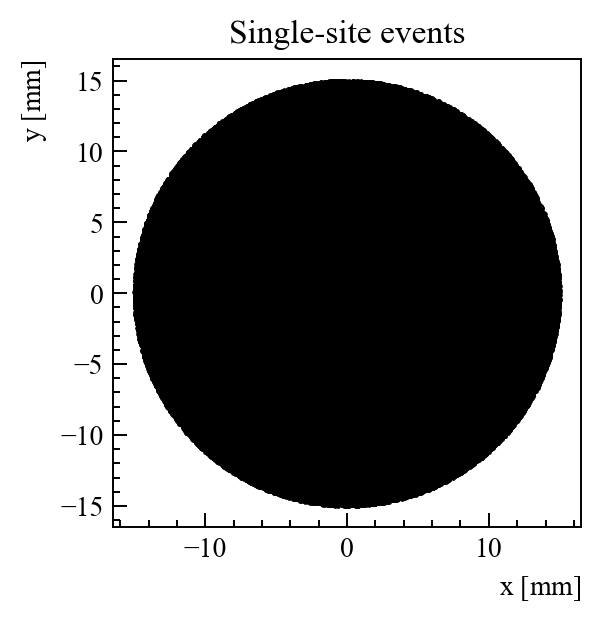

In [3]:
num_events = 100_000 # number of training images for each case
n_photons = 2e6 # number of photons produced in each event *np.ones(num_events)[:, None]

# max_sep = 300. # mm, maximum separation between MS events considered
# max_sep = 460 - 40*np.round(2*np.log10(n_photons))
max_sep = 30.

# get twice the number of sites needed since some events (such as those in which downward 
# fluctuations causes no photons to be produced) will end up being discarded
site_ss = get_ss_events(2*num_events, max_sep)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site_ss[:,0], site_ss[:,1], s=0.5)
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Single-site events')
fig.savefig('ss_event_sites.png')

#### Case 2: multi-site events

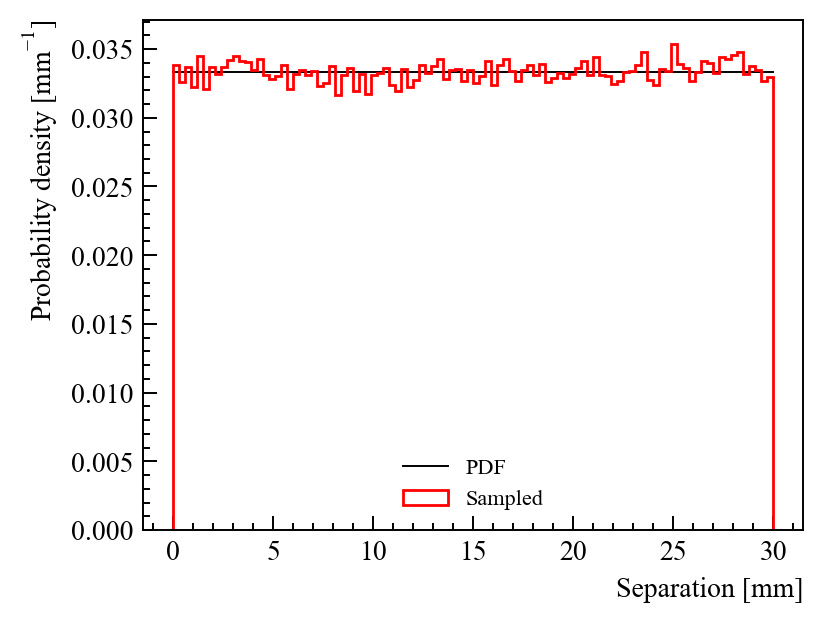

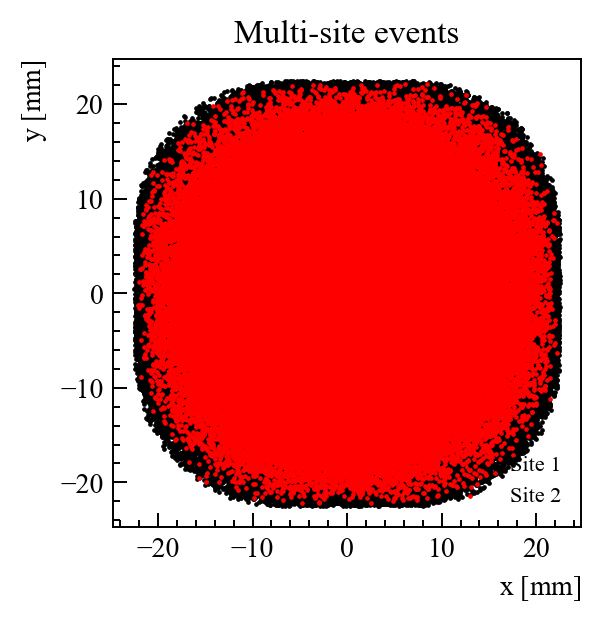

In [112]:
site1, site2 = get_ms_events(2*num_events, max_sep, uniform_separation)

seps_sampled = np.sqrt(np.sum((site1 - site2)**2, axis=1))
sep_array = np.linspace(0, max_sep, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(sep_array, uniform_separation(sep_array, max_sep/2.), label='PDF')
ax.hist(seps_sampled, bins=100, histtype='step', density=True, label='Sampled')
ax.set_xlabel('Separation [mm]')
ax.set_ylabel('Probability density [mm$^{-1}$]')
ax.legend()
fig.savefig('sep_dist_exp.png')

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site1[:,0], site1[:,1], s=0.5, label='Site 1')
ax.scatter(site2[:,0], site2[:,1], s=0.5, label='Site 2')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Multi-site events')
ax.legend()
fig.savefig('ms_event_sites.png')

### Compute the number of counts on each PMT

In [113]:
# single site
r_points = np.sqrt(np.sum((site_ss[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts = n_photons*lrf(r_points/10., *lrf_params)
det_counts_ss = np.random.poisson(mean_counts)

# multi site
r_points_1 = np.sqrt(np.sum((site1[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
r_points_2 = np.sqrt(np.sum((site2[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts_1 = 0.5*n_photons*lrf(r_points_1/10., *lrf_params)
mean_counts_2 = 0.5*n_photons*lrf(r_points_2/10., *lrf_params)
det_counts_ms = np.random.poisson(mean_counts_1 + mean_counts_2)

eff = np.mean(np.sum(det_counts_ss, axis=1))/n_photons

### Plot sample PMT hit patterns

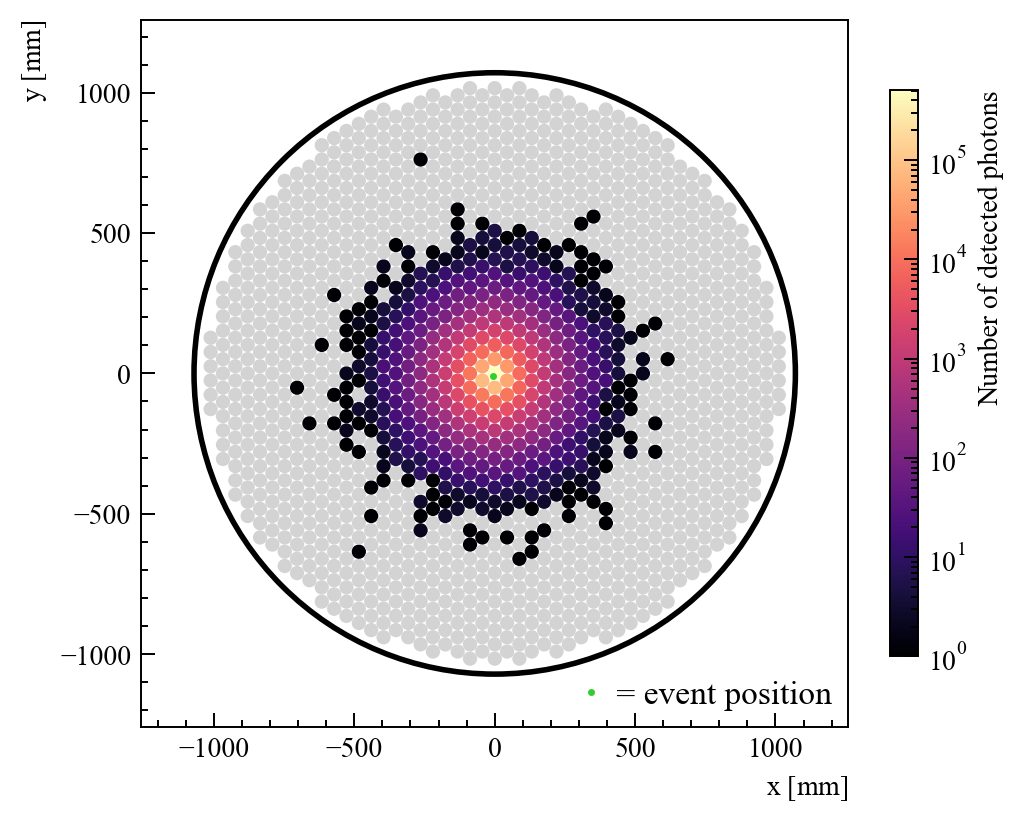

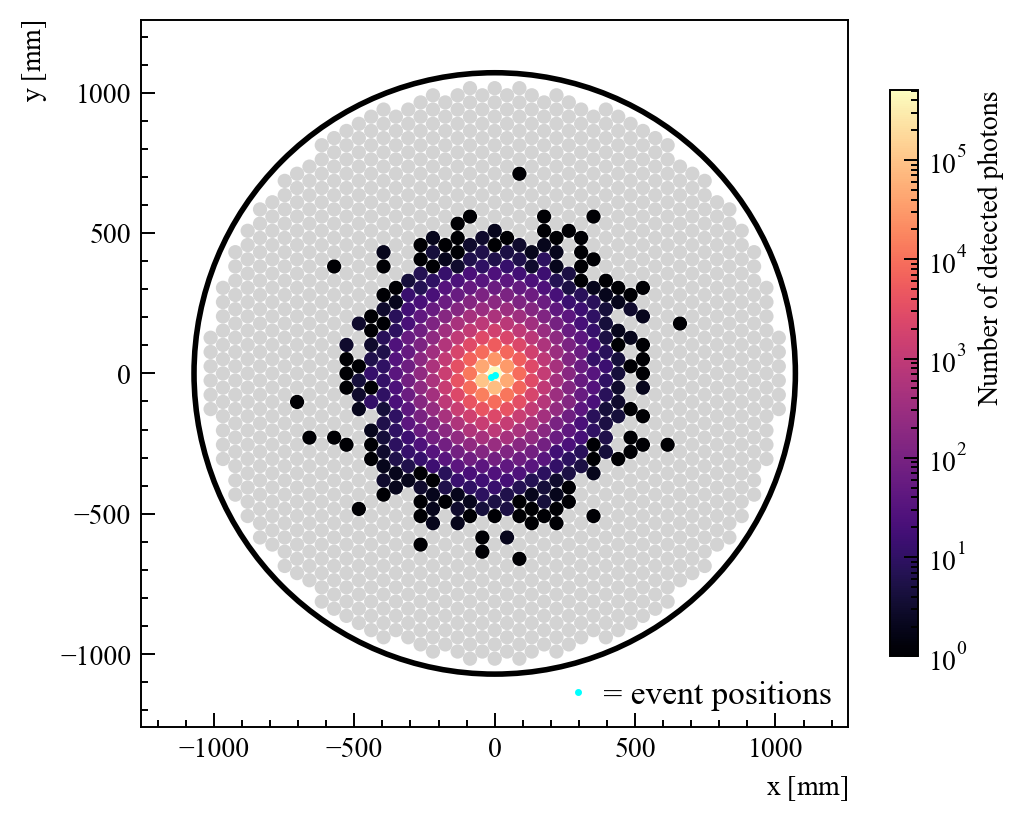

In [32]:
fig, ax = plot_ss_event(site_ss, det_counts_ss, 0, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ss.png')
fig, ax = plot_ms_event(site1, site2, det_counts_ms, 2, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ms.png')

### Build the training images

In [33]:
images_ms, pmt_indices_ms, event_ids_ms = images_from_events_parallel(det_counts_ms, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_events)
images_ss, pmt_indices_ss, event_ids_ss = images_from_events_parallel(det_counts_ss, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_events)

python(53183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53188) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53193) Malloc

In [34]:
# np.savez('data/hit_pattern_data.npz', det_counts_ms=det_counts_ms, pmt_indices_ms=pmt_indices_ms, \
#          pmt_pos_array=pmt_pos_array, pmt_diam=pmt_diam, radius_tpc=radius_tpc, images_ms=images_ms, \
#          event_ids_ms=event_ids_ms, site1=site1, site2=site2)

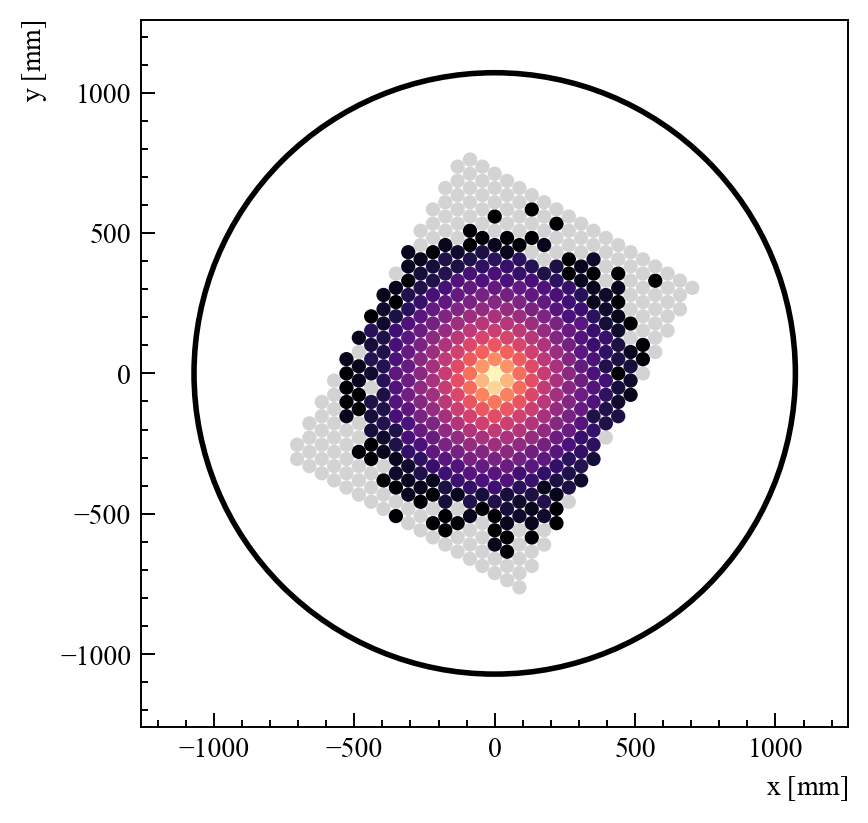

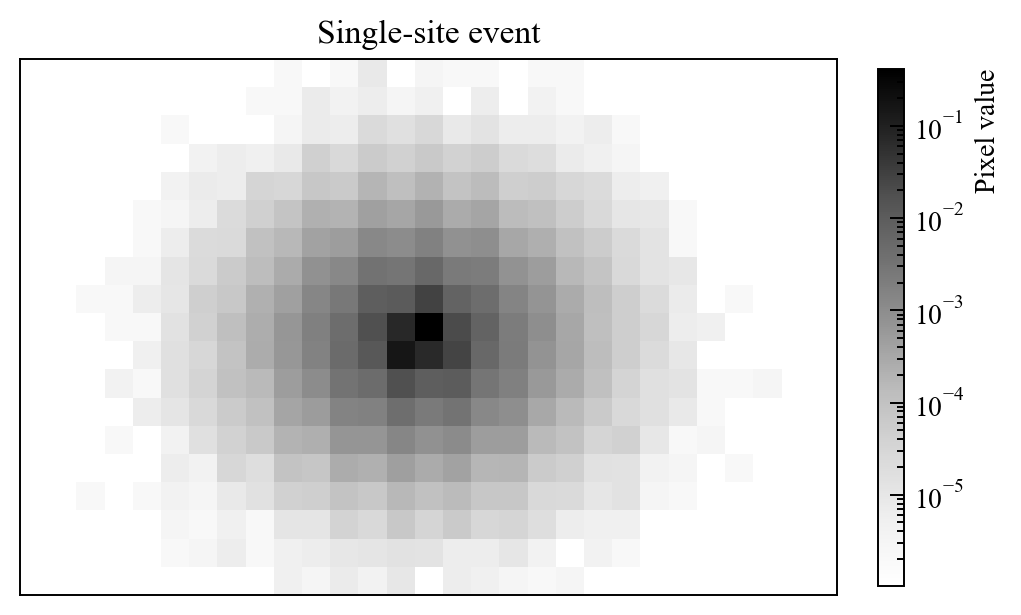

In [35]:
event_id = 9
ind = event_ids_ms[event_id]

fig, _ = plot_selected_pmts(det_counts_ms, pmt_indices_ms, ind, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('ss_selected_pmts.png')

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
im = ax.imshow(images_ms[event_id].T, origin='lower', norm=mcolors.LogNorm(), cmap='Greys')
fig.colorbar(im, shrink=0.66, label='Pixel value')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Single-site event')
fig.savefig('ss_sample_image.png')

### Scramble data and divide into training and validation

In [36]:
truth_ms = np.zeros(images_ms.shape[0])
truth_ss = np.ones(images_ss.shape[0])

images_all = np.vstack((images_ss, images_ms))
truth_all = np.hstack((truth_ss, truth_ms))

permutation = np.random.permutation(truth_all.shape[0])

images_scrambled = images_all[permutation, ...]
truth_scrambled = truth_all[permutation, ...]

validation_split = 0.2

images_training = images_scrambled[:int(-validation_split*images_scrambled.shape[0])]
truth_training = truth_scrambled[:int(-validation_split*truth_scrambled.shape[0])]
images_validation = images_scrambled[int(-validation_split*images_scrambled.shape[0]):]
truth_validation = truth_scrambled[int(-validation_split*truth_scrambled.shape[0]):]
indices_validation = permutation[int(-validation_split*permutation.shape[0]):]

descrip = 'final_run'

np.savez('data/images_{:.0e}_events_{:.0e}_photons_{}.npz'.format(num_events, n_photons, descrip), images_training=images_training, \
         truth_training=truth_training, images_validation=images_validation, truth_validation=truth_validation, \
         indices_validation=indices_validation, images_all=images_all, truth_all=truth_all)

# num_events = 50000
# n_photons = 1e4
# loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_photons))
# images_training = loaded['images_training']
# truth_training = loaded['truth_training']
# images_validation = loaded['images_validation']
# truth_validation = loaded['truth_validation']
# indices_validation = loaded['indices_validation']
# images_all = loaded['images_all']
# truth_all = loaded['truth_all']

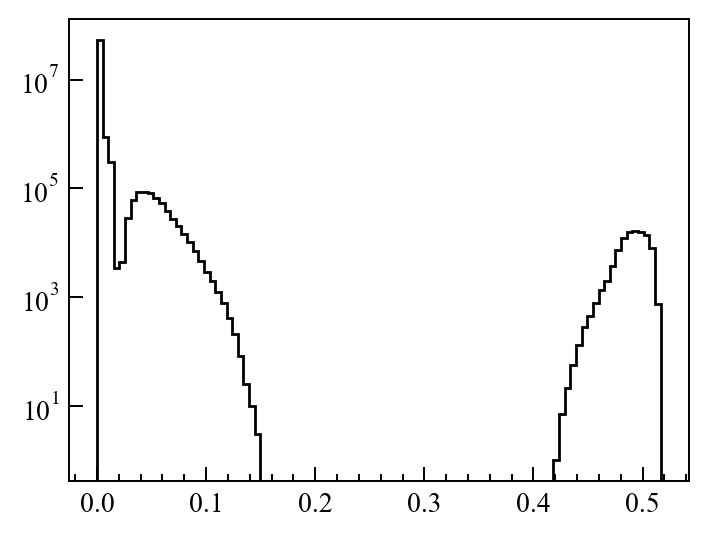

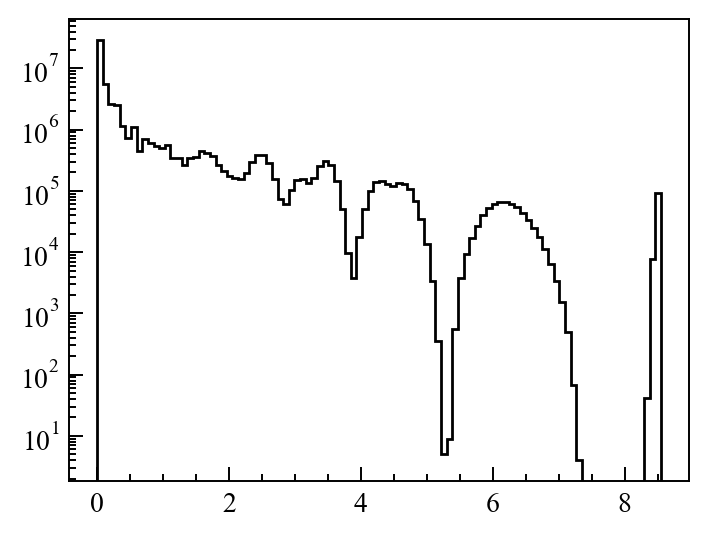

In [76]:
plt.hist(images_ms.ravel(), histtype='step', bins=100)
plt.yscale('log')

plt.figure()
plt.hist(np.log1p(1e4*images_ms).ravel(), histtype='step', bins=100)
plt.yscale('log')

In [4]:
num_photons =  [4e1, 8e1, 2e2, 6e2, 2e3, 6e3, 2e4, 6e4, 2e5, 6e5, 2e6]

for n_p in num_photons:
    descrip = 'final_run'
    loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons_{}.npz'.format(num_events, n_p, descrip))
    images_training = loaded['images_training']
    truth_training = loaded['truth_training']
    images_validation = loaded['images_validation']
    truth_validation = loaded['truth_validation']
    indices_validation = loaded['indices_validation']
    images_all = loaded['images_all']
    truth_all = loaded['truth_all']

    # model = ResNet14(input_shape=images_all[0,:,:,None].shape)
    model = MiniVGG(input_shape=images_all[0,:,:,None].shape)
    model.summary()

    lr_scheduler = callbacks.LearningRateScheduler(scheduler)
    earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(images_training, truth_training,
        batch_size=128,
        epochs=30,
        callbacks=[lr_scheduler, earlystopping],
        validation_data=(images_validation, truth_validation)
    )

    descrip = 'vgg'
    model.save('data/' + model.name + '_{:.0e}_events_{:.0e}_photons_{}.keras'.format(num_events, n_p, descrip))

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - AUC: 0.9072 - accuracy: 0.8536 - loss: 0.5504 - val_AUC: 0.9209 - val_accuracy: 0.8635 - val_loss: 0.4478 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - AUC: 0.9160 - accuracy: 0.8682 - loss: 0.3794 - val_AUC: 0.9200 - val_accuracy: 0.8556 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.9180 - accuracy: 0.8708 - loss: 0.3441 - val_AUC: 0.9211 - val_accuracy: 0.8533 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - AUC: 0.9191 - accuracy: 0.8729 - loss: 0.3316 - val_AUC: 0.9168 - val_accuracy: 0.7257 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.9196 - accuracy: 0.8735 - loss: 0.3270 - val_AUC: 0.8945 - val_accuracy: 0.6835 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - AUC: 0.9207 - accuracy: 0.8750 - loss: 0.4988 - val_AUC: 0.9350 - val_accuracy: 0.8910 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9273 - accuracy: 0.8861 - loss: 0.3378 - val_AUC: 0.9364 - val_accuracy: 0.8030 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AUC: 0.9287 - accuracy: 0.8878 - loss: 0.3072 - val_AUC: 0.9366 - val_accuracy: 0.8880 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AUC: 0.9299 - accuracy: 0.8890 - loss: 0.2977 - val_AUC: 0.8953 - val_accuracy: 0.7021 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AUC: 0.9306 - accuracy: 0.8907 - loss: 0.2929 - val_AUC: 0.9367 - val_accuracy: 0.8902 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - AUC: 0.9254 - accuracy: 0.8855 - loss: 0.4878 - val_AUC: 0.9358 - val_accuracy: 0.8130 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9312 - accuracy: 0.8952 - loss: 0.3304 - val_AUC: 0.9382 - val_accuracy: 0.8923 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9326 - accuracy: 0.8968 - loss: 0.2981 - val_AUC: 0.9393 - val_accuracy: 0.6935 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - AUC: 0.9334 - accuracy: 0.8979 - loss: 0.2881 - val_AUC: 0.9373 - val_accuracy: 0.8763 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9337 - accuracy: 0.8984 - loss: 0.2841 - val_AUC: 0.8995 - val_accuracy: 0.4976 - val_loss: 2.1172 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - AUC: 0.9276 - accuracy: 0.8884 - loss: 0.4905 - val_AUC: 0.8703 - val_accuracy: 0.5246 - val_loss: 1.8823 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - AUC: 0.9358 - accuracy: 0.9008 - loss: 0.3250 - val_AUC: 0.9442 - val_accuracy: 0.8836 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9372 - accuracy: 0.9020 - loss: 0.2898 - val_AUC: 0.9448 - val_accuracy: 0.8880 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9384 - accuracy: 0.9040 - loss: 0.2783 - val_AUC: 0.9442 - val_accuracy: 0.9039 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9386 - accuracy: 0.9042 - loss: 0.2747 - val_AUC: 0.9449 - val_accuracy: 0.8888 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - AUC: 0.9246 - accuracy: 0.8867 - loss: 0.4968 - val_AUC: 0.9279 - val_accuracy: 0.6158 - val_loss: 1.1871 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - AUC: 0.9363 - accuracy: 0.9018 - loss: 0.3259 - val_AUC: 0.9417 - val_accuracy: 0.8886 - val_loss: 0.3399 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - AUC: 0.9376 - accuracy: 0.9046 - loss: 0.2912 - val_AUC: 0.9210 - val_accuracy: 0.6873 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - AUC: 0.9378 - accuracy: 0.9051 - loss: 0.2814 - val_AUC: 0.9367 - val_accuracy: 0.8335 - val_loss: 0.4264 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - AUC: 0.9381 - accuracy: 0.9050 - loss: 0.2778 - val_AUC: 0.9412 - val_accuracy: 0.9057 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - AUC: 0.9182 - accuracy: 0.8726 - loss: 0.5194 - val_AUC: 0.9383 - val_accuracy: 0.4988 - val_loss: 1.6710 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.9335 - accuracy: 0.8945 - loss: 0.3400 - val_AUC: 0.9375 - val_accuracy: 0.8325 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9349 - accuracy: 0.8963 - loss: 0.3081 - val_AUC: 0.9422 - val_accuracy: 0.9023 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AUC: 0.9346 - accuracy: 0.8963 - loss: 0.2994 - val_AUC: 0.9450 - val_accuracy: 0.5043 - val_loss: 0.7742 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.9356 - accuracy: 0.8971 - loss: 0.2943 - val_AUC: 0.9453 - val_accuracy: 0.9067 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - AUC: 0.9015 - accuracy: 0.8509 - loss: 0.5659 - val_AUC: 0.9296 - val_accuracy: 0.4963 - val_loss: 1.5164 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9235 - accuracy: 0.8806 - loss: 0.3734 - val_AUC: 0.8375 - val_accuracy: 0.4963 - val_loss: 2.7088 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9252 - accuracy: 0.8833 - loss: 0.3383 - val_AUC: 0.8983 - val_accuracy: 0.5181 - val_loss: 1.5294 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9266 - accuracy: 0.8849 - loss: 0.3292 - val_AUC: 0.5000 - val_accuracy: 0.4963 - val_loss: 7.9076 - learning_rate: 0.0010


Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - AUC: 0.8378 - accuracy: 0.7678 - loss: 0.6944 - val_AUC: 0.8922 - val_accuracy: 0.4998 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.8774 - accuracy: 0.8150 - loss: 0.4811 - val_AUC: 0.8752 - val_accuracy: 0.4998 - val_loss: 2.0505 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.8827 - accuracy: 0.8237 - loss: 0.4342 - val_AUC: 0.8661 - val_accuracy: 0.4998 - val_loss: 2.1774 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.8872 - accuracy: 0.8291 - loss: 0.4178 - val_AUC: 0.8928 - val_accuracy: 0.7718 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.8897 - accuracy: 0.8301 - loss: 0.4107 - val_AUC: 0.8593 - val_accuracy: 0.5269 - val_loss: 1.5584 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - AUC: 0.7365 - accuracy: 0.6660 - loss: 0.8211 - val_AUC: 0.5757 - val_accuracy: 0.4956 - val_loss: 3.2440 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.8742 - accuracy: 0.8067 - loss: 0.5180 - val_AUC: 0.8571 - val_accuracy: 0.4956 - val_loss: 1.9830 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.8883 - accuracy: 0.8241 - loss: 0.4562 - val_AUC: 0.8641 - val_accuracy: 0.5109 - val_loss: 1.6297 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AUC: 0.8938 - accuracy: 0.8319 - loss: 0.4363 - val_AUC: 0.5000 - val_accuracy: 0.4956 - val_loss: 4.1962 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.8960 - accuracy: 0.8347 - loss: 0.4279 - val_AUC: 0.8888 - val_accuracy: 0.5044 - val_loss: 1.9153 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - AU

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - AUC: 0.8723 - accuracy: 0.7998 - loss: 0.6685 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 4.6463 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - AUC: 0.9220 - accuracy: 0.8653 - loss: 0.4269 - val_AUC: 0.5000 - val_accuracy: 0.4983 - val_loss: 11.0989 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9318 - accuracy: 0.8775 - loss: 0.3677 - val_AUC: 0.9418 - val_accuracy: 0.6874 - val_loss: 0.8240 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9354 - accuracy: 0.8843 - loss: 0.3471 - val_AUC: 0.8949 - val_accuracy: 0.7894 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - AUC: 0.9379 - accuracy: 0.8876 - loss: 0.3348 - val_AUC: 0.9248 - val_accuracy: 0.5017 - val_loss: 1.5877 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - A

Model: "mini_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 29, 19, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 29, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 29, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 29, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 14, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 14, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 14, 9, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 14, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 14, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 7, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 7, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 7, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 7, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 128)            │             

 Total params: 122,161 (477.19 KB)

 Trainable params: 121,681 (475.32 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - AUC: 0.8821 - accuracy: 0.8105 - loss: 0.6413 - val_AUC: 0.5000 - val_accuracy: 0.4991 - val_loss: 16.0570 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - AUC: 0.9232 - accuracy: 0.8670 - loss: 0.4121 - val_AUC: 0.8119 - val_accuracy: 0.4991 - val_loss: 2.3411 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9322 - accuracy: 0.8787 - loss: 0.3573 - val_AUC: 0.6257 - val_accuracy: 0.4991 - val_loss: 3.8233 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - AUC: 0.9369 - accuracy: 0.8850 - loss: 0.3378 - val_AUC: 0.8175 - val_accuracy: 0.6258 - val_loss: 1.9745 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - AUC: 0.9394 - accuracy: 0.8878 - loss: 0.3283 - val_AUC: 0.9297 - val_accuracy: 0.7313 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - A

In [86]:
num_photons = [4e1, 8e1, 2e2, 6e2, 2e3, 6e3, 2e4, 6e4, 2e5, 6e5, 2e6]
descrip = 'final_run'

for n_p in num_photons:
    loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons_{}.npz'.format(num_events, n_p, descrip))
    images_training = loaded['images_training']
    truth_training = loaded['truth_training']
    images_validation = loaded['images_validation']
    truth_validation = loaded['truth_validation']
    indices_validation = loaded['indices_validation']
    images_all = loaded['images_all']
    truth_all = loaded['truth_all']

    model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons_{}.keras'.format(num_events, n_p, descrip))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    model.summary()

    lr_scheduler = callbacks.LearningRateScheduler(scheduler)
    earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(images_training, truth_training,
        batch_size=128,
        epochs=30,
        callbacks=[lr_scheduler, earlystopping],
        validation_data=(images_validation, truth_validation)
    )

    model.save('data/' + model.name + '_{:.0e}_events_{:.0e}_photons_{}_retrained.keras'.format(num_events, n_p, descrip))


Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 29, 19, 8) │         72 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 29, 19, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 19, 8) │        576 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 29, 19, 8) │        576 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 29, 19, 8) │          0 │ conv2d_2[0][0],   │
│                     │                   │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 29, 19, 8) │        576 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 29, 19, 8) │        576 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 29, 19, 8) │          0 │ conv2d_4[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - AUC: 0.9033 - acc: 0.8827 - loss: 0.2835 - val_AUC: 0.9000 - val_acc: 0.8829 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9035 - acc: 0.8837 - loss: 0.2821 - val_AUC: 0.8999 - val_acc: 0.8823 - val_loss: 0.2910 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - AUC: 0.9038 - acc: 0.8841 - loss: 0.2810 - val_AUC: 0.8979 - val_acc: 0.8796 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - AUC: 0.9043 - acc: 0.8843 - loss: 0.2799 - val_AUC: 0.8913 - val_acc: 0.8590 - val_loss: 0.3012 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9044 - acc: 0.8846 - loss: 0.2796 - val_AUC: 0.8965 - val_acc: 0.8748 - val_loss: 0.2917 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9045 - acc: 0.8849 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 29, 19, 8) │          0 │ conv2d_17[0][0],  │
│                     │                   │            │ re_lu_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_6[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 29, 19, 8) │          0 │ conv2d_19[0][0],  │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_7[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - AUC: 0.9167 - acc: 0.9001 - loss: 0.2517 - val_AUC: 0.9153 - val_acc: 0.9018 - val_loss: 0.2508 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.9166 - acc: 0.9009 - loss: 0.2504 - val_AUC: 0.9173 - val_acc: 0.8999 - val_loss: 0.2505 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - AUC: 0.9170 - acc: 0.9013 - loss: 0.2497 - val_AUC: 0.9155 - val_acc: 0.9008 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9170 - acc: 0.9014 - loss: 0.2493 - val_AUC: 0.9157 - val_acc: 0.8994 - val_loss: 0.2499 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9175 - acc: 0.9012 - loss: 0.2486 - val_AUC: 0.9151 - val_acc: 0.8984 - val_loss: 0.2501 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9173 - acc: 0.9012 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_32[0][0],  │
│                     │                   │            │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_12[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_34[0][0],  │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_13[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - AUC: 0.9224 - acc: 0.9090 - loss: 0.2366 - val_AUC: 0.9212 - val_acc: 0.9082 - val_loss: 0.2371 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - AUC: 0.9228 - acc: 0.9099 - loss: 0.2350 - val_AUC: 0.9215 - val_acc: 0.9082 - val_loss: 0.2368 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - AUC: 0.9233 - acc: 0.9097 - loss: 0.2346 - val_AUC: 0.9224 - val_acc: 0.9061 - val_loss: 0.2377 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9234 - acc: 0.9105 - loss: 0.2341 - val_AUC: 0.9218 - val_acc: 0.9078 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - AUC: 0.9236 - acc: 0.9106 - loss: 0.2337 - val_AUC: 0.9214 - val_acc: 0.9086 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9237 - acc: 0.9108 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_47[0][0],  │
│                     │                   │            │ re_lu_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_18[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_49[0][0],  │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_19[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - AUC: 0.9317 - acc: 0.9217 - loss: 0.2130 - val_AUC: 0.9287 - val_acc: 0.9200 - val_loss: 0.2177 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9319 - acc: 0.9219 - loss: 0.2123 - val_AUC: 0.9286 - val_acc: 0.9199 - val_loss: 0.2177 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - AUC: 0.9321 - acc: 0.9222 - loss: 0.2118 - val_AUC: 0.9278 - val_acc: 0.9179 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9322 - acc: 0.9223 - loss: 0.2116 - val_AUC: 0.9287 - val_acc: 0.9193 - val_loss: 0.2178 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - AUC: 0.9324 - acc: 0.9225 - loss: 0.2111 - val_AUC: 0.9286 - val_acc: 0.9193 - val_loss: 0.2182 - learning_rate: 1.0000e-04


Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_56[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_62[0][0],  │
│                     │                   │            │ re_lu_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_24[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_59 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_60 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_64[0][0],  │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_25[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_61 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - AUC: 0.9373 - acc: 0.9290 - loss: 0.1996 - val_AUC: 0.9332 - val_acc: 0.9254 - val_loss: 0.2086 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9376 - acc: 0.9288 - loss: 0.1995 - val_AUC: 0.9334 - val_acc: 0.9258 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - AUC: 0.9377 - acc: 0.9291 - loss: 0.1992 - val_AUC: 0.9328 - val_acc: 0.9216 - val_loss: 0.2103 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9379 - acc: 0.9296 - loss: 0.1985 - val_AUC: 0.9339 - val_acc: 0.9244 - val_loss: 0.2081 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9382 - acc: 0.9299 - loss: 0.1983 - val_AUC: 0.9332 - val_acc: 0.9249 - val_loss: 0.2079 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9382 - acc: 0.9296 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_70 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_70[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_71 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_77[0][0],  │
│                     │                   │            │ re_lu_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_30[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_79[0][0],  │
│                     │                   │            │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_31[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_75 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - AUC: 0.9312 - acc: 0.9205 - loss: 0.2155 - val_AUC: 0.9350 - val_acc: 0.9230 - val_loss: 0.2094 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9323 - acc: 0.9227 - loss: 0.2120 - val_AUC: 0.9360 - val_acc: 0.9263 - val_loss: 0.2064 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9331 - acc: 0.9238 - loss: 0.2099 - val_AUC: 0.9347 - val_acc: 0.9217 - val_loss: 0.2081 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9339 - acc: 0.9249 - loss: 0.2081 - val_AUC: 0.9363 - val_acc: 0.9277 - val_loss: 0.2053 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - AUC: 0.9341 - acc: 0.9253 - loss: 0.2074 - val_AUC: 0.9359 - val_acc: 0.9259 - val_loss: 0.2047 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9348 - acc: 0.9258 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 29, 19, 8) │         72 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_84 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_84[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_85 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_85[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_86 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_92[0][0],  │
│                     │                   │            │ re_lu_84[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_36[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_87 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_87[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_88 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_88[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_94[0][0],  │
│                     │                   │            │ add_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_37[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_89 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - AUC: 0.9253 - acc: 0.9123 - loss: 0.2299 - val_AUC: 0.9217 - val_acc: 0.9143 - val_loss: 0.2377 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9260 - acc: 0.9135 - loss: 0.2272 - val_AUC: 0.9276 - val_acc: 0.9175 - val_loss: 0.2236 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9268 - acc: 0.9143 - loss: 0.2260 - val_AUC: 0.9289 - val_acc: 0.9182 - val_loss: 0.2221 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9271 - acc: 0.9151 - loss: 0.2244 - val_AUC: 0.9292 - val_acc: 0.9112 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9273 - acc: 0.9151 - loss: 0.2243 - val_AUC: 0.9281 - val_acc: 0.9141 - val_loss: 0.2218 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.9280 - acc: 0.9160 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_105[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_98 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_98[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_99 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_99[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_106[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_100 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_100[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_107[0][0], │
│                     │                   │            │ re_lu_98[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_42[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_101 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_101[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_102 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_102[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_43 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_109[0][0], │
│                     │                   │            │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_43[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_103 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - AUC: 0.8986 - acc: 0.8725 - loss: 0.2912 - val_AUC: 0.8980 - val_acc: 0.8717 - val_loss: 0.2889 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.8996 - acc: 0.8755 - loss: 0.2871 - val_AUC: 0.9009 - val_acc: 0.8707 - val_loss: 0.2848 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.9000 - acc: 0.8771 - loss: 0.2850 - val_AUC: 0.8958 - val_acc: 0.8800 - val_loss: 0.2963 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.9008 - acc: 0.8780 - loss: 0.2836 - val_AUC: 0.8982 - val_acc: 0.8809 - val_loss: 0.2883 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - AUC: 0.9013 - acc: 0.8788 - loss: 0.2819 - val_AUC: 0.8994 - val_acc: 0.8697 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9022 - acc: 0.8791 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_112 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_112[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_113 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_113[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_114 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_114[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_122[0][0], │
│                     │                   │            │ re_lu_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_48[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_115 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_115[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_123[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_116 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_116[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_124[0][0], │
│                     │                   │            │ add_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_49[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_117 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - AUC: 0.9007 - acc: 0.8769 - loss: 0.2893 - val_AUC: 0.7565 - val_acc: 0.7049 - val_loss: 0.5098 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9021 - acc: 0.8795 - loss: 0.2856 - val_AUC: 0.7522 - val_acc: 0.7000 - val_loss: 0.5371 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9021 - acc: 0.8801 - loss: 0.2841 - val_AUC: 0.6332 - val_acc: 0.5895 - val_loss: 0.8717 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - AUC: 0.9024 - acc: 0.8811 - loss: 0.2833 - val_AUC: 0.8580 - val_acc: 0.8419 - val_loss: 0.4099 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9024 - acc: 0.8804 - loss: 0.2839 - val_AUC: 0.6965 - val_acc: 0.6509 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - AUC: 0.9030 - acc: 0.8816 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_135[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_126 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_126[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_127 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_127[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_136[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_128 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_137[0][0], │
│                     │                   │            │ re_lu_126[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_54[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_129 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_129[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_138[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_130 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_130[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_139[0][0], │
│                     │                   │            │ add_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_55[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_131 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - AUC: 0.9503 - acc: 0.9396 - loss: 0.1680 - val_AUC: 0.8335 - val_acc: 0.7994 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - AUC: 0.9513 - acc: 0.9421 - loss: 0.1633 - val_AUC: 0.9127 - val_acc: 0.8815 - val_loss: 0.2224 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - AUC: 0.9509 - acc: 0.9413 - loss: 0.1633 - val_AUC: 0.9487 - val_acc: 0.9411 - val_loss: 0.1769 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - AUC: 0.9514 - acc: 0.9423 - loss: 0.1617 - val_AUC: 0.9543 - val_acc: 0.9439 - val_loss: 0.1561 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - AUC: 0.9518 - acc: 0.9430 - loss: 0.1608 - val_AUC: 0.9394 - val_acc: 0.9349 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - AUC: 0.9517 - acc: 0.9431 - loss

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_150[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_140 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_140[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_141 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_141[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_151[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_142 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_142[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_152[0][0], │
│                     │                   │            │ re_lu_140[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_60[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_143 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_143[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_144 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_144[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_154[0][0], │
│                     │                   │            │ add_60[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_61[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_145 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 44,521 (173.91 KB)

 Trainable params: 43,945 (171.66 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - AUC: 0.9612 - acc: 0.9538 - loss: 0.1374 - val_AUC: 0.9611 - val_acc: 0.9563 - val_loss: 0.1384 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - AUC: 0.9614 - acc: 0.9548 - loss: 0.1347 - val_AUC: 0.5829 - val_acc: 0.5579 - val_loss: 1.1477 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - AUC: 0.9625 - acc: 0.9564 - loss: 0.1320 - val_AUC: 0.9629 - val_acc: 0.9588 - val_loss: 0.1320 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9624 - acc: 0.9566 - loss: 0.1310 - val_AUC: 0.8339 - val_acc: 0.7872 - val_loss: 0.3592 - learning_rate: 1.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - AUC: 0.9634 - acc: 0.9576 - loss: 0.1292 - val_AUC: 0.9590 - val_acc: 0.9474 - val_loss: 0.1409 - learning_rate: 1.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - AUC: 0.9631 - acc: 0.9573 - loss

### Build and train the CNN

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 29, 19, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 29, 19, 8) │        144 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_54[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_55 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_59[0][0],  │
│                     │                   │            │ re_lu_54[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_24[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_61[0][0],  │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_25[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_59 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 68,017 (265.69 KB)

 Trainable params: 67,249 (262.69 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - AUC: 0.8591 - acc: 0.8058 - loss: 0.4182 - val_AUC: 0.8832 - val_acc: 0.8589 - val_loss: 0.3332 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.8937 - acc: 0.8692 - loss: 0.3074 - val_AUC: 0.8928 - val_acc: 0.8608 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9034 - acc: 0.8815 - loss: 0.2833 - val_AUC: 0.8453 - val_acc: 0.7997 - val_loss: 0.3584 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9071 - acc: 0.8881 - loss: 0.2724 - val_AUC: 0.8718 - val_acc: 0.8271 - val_loss: 0.3173 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9112 - acc: 0.8924 - loss: 0.2637 - val_AUC: 0.8796 - val_acc: 0.8457 - val_loss: 0.3091 - learning_rate: 1.0000e-04


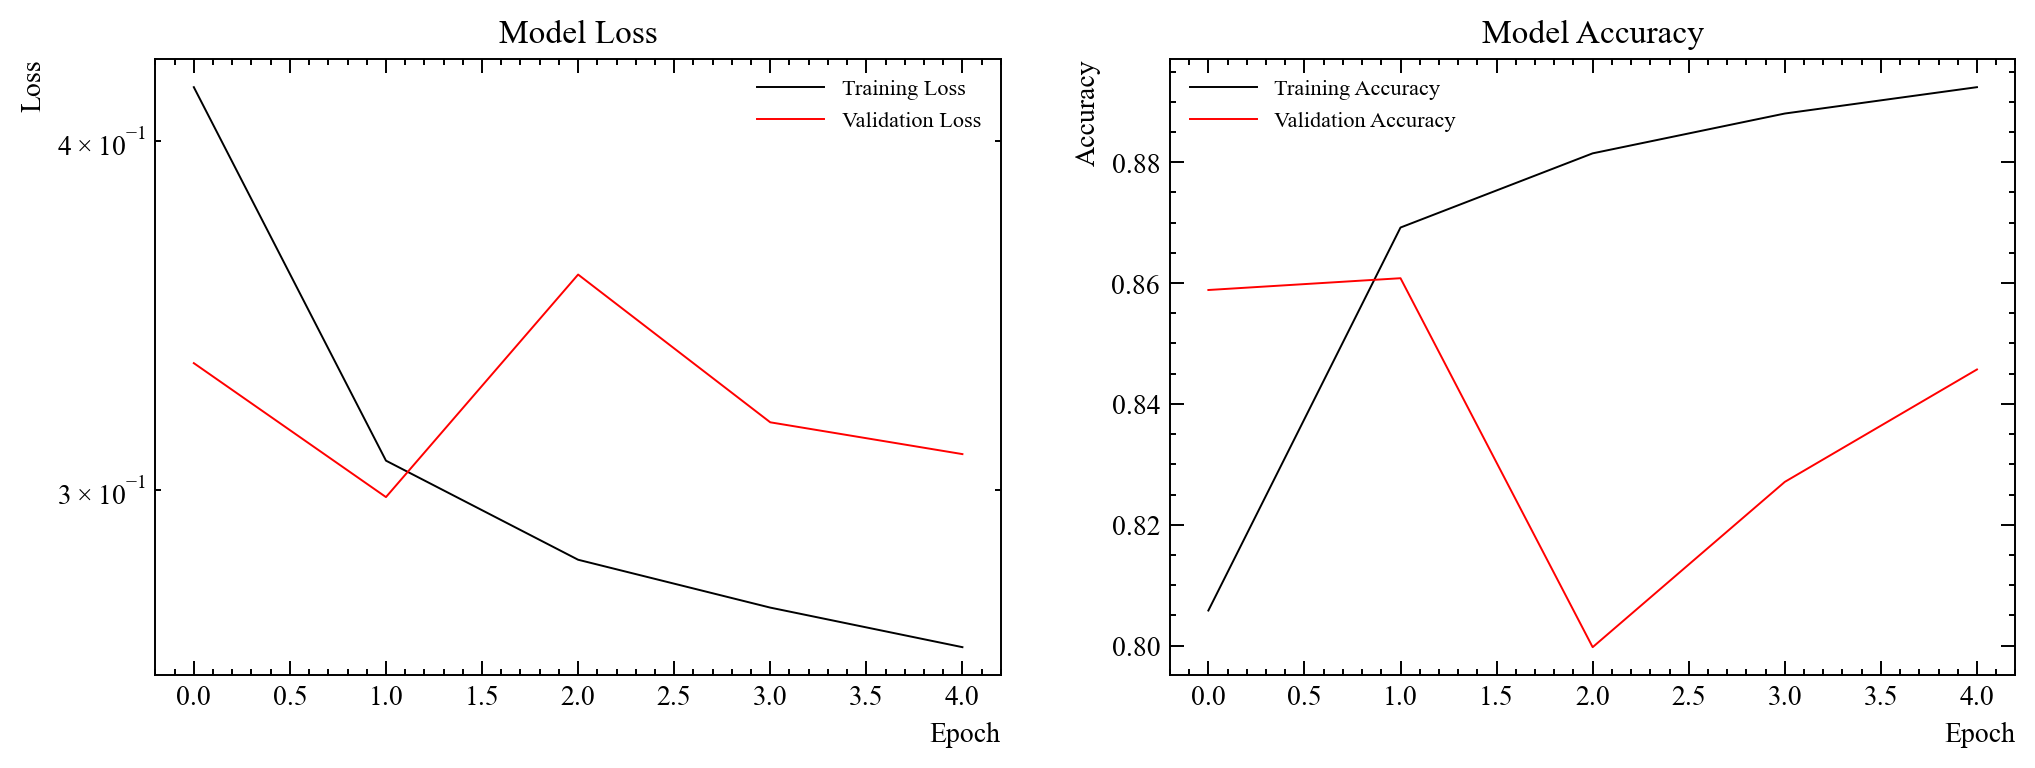

In [67]:
# model = ResNet14(input_shape=images_all[0,:,:,None].shape, num_classes=1)
model = ResNet14(input_shape=images_all[0].shape, num_classes=1)
model.summary()

lr_scheduler = callbacks.LearningRateScheduler(scheduler)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(images_training, truth_training,
    batch_size=128,
    epochs=30,
    callbacks=[lr_scheduler, earlystopping],
    validation_data=(images_validation, truth_validation)
)

model.save('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_photons))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_training.png')

### Plot performance on the validation data

In [204]:
n_photons = 3e3
model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_photons))
loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_photons))
images_training = loaded['images_training']
truth_training = loaded['truth_training']
images_validation = loaded['images_validation']
truth_validation = loaded['truth_validation']
indices_validation = loaded['indices_validation']
images_all = loaded['images_all']
truth_all = loaded['truth_all']

Youden optimal cut keeps 99.1% of signal events and removes 87.6% of background events.


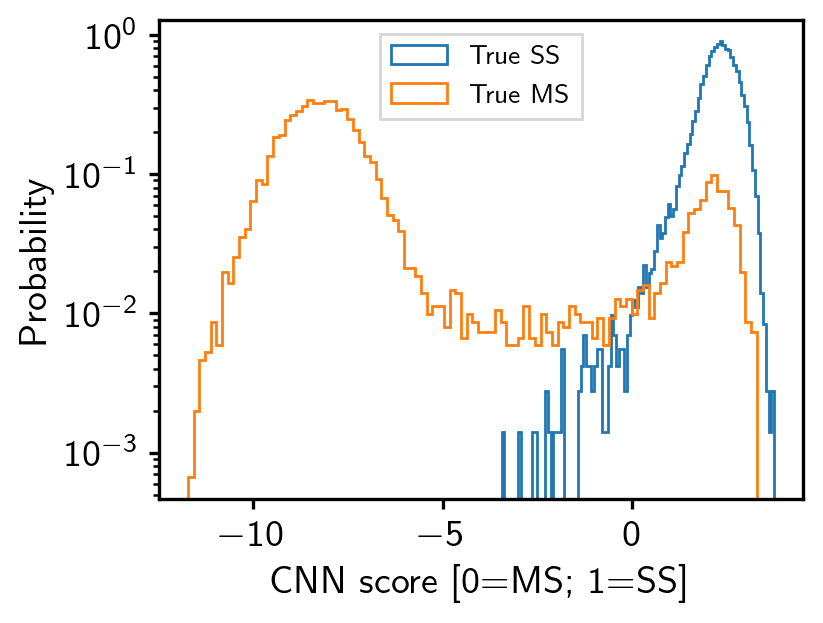

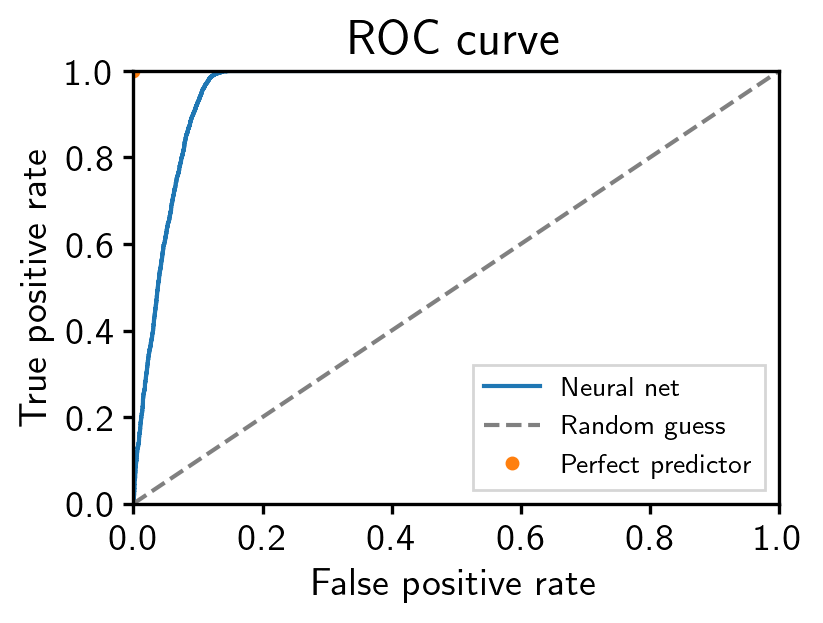

In [205]:
# get the validation data
ss_validation = images_all[indices_validation][indices_validation < images_ss.shape[0]]
ms_validation = images_all[indices_validation][indices_validation >= images_ss.shape[0]]

# run the validation images through the trained model
ss_predictions = model(ss_validation[:,:,:,None], training=False)[:,0].numpy()
ms_predictions = model(ms_validation[:,:,:,None], training=False)[:,0].numpy()

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.hist(ss_predictions, bins=100, histtype='step', density=True, label='True SS')
ax.hist(ms_predictions, bins=100, histtype='step', density=True, label='True MS')
ax.set_yscale('log')
ax.set_xlabel('CNN score [0=MS; 1=SS]')
ax.set_ylabel('Probability')
ax.legend()
fig.savefig('cnn_score_dists.png')

y_pred = np.array(np.array(model(images_validation))[:,0])
y_true = np.copy(truth_validation)

sorted_indices = np.argsort(-y_pred)
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

P = np.sum(y_true)
N = len(y_true) - P

tpr = np.cumsum(y_true_sorted)/P
fpr = np.cumsum(1 - y_true_sorted)/N

youden = tpr - fpr - 1
opt_ind = np.argmax(youden)

print('Youden optimal cut keeps {:.1f}% of signal events and removes {:.1f}% of background events.'\
      .format(100*tpr[opt_ind], 100*(1. - fpr[opt_ind])))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(fpr, tpr, label='Neural net')
ax.plot([0, 1], [0, 1], ls='--', color='grey', label='Random guess')
ax.plot([0], [1], marker='o', ls='none', ms=4, label='Perfect predictor')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
fig.savefig('cnn_roc.png')

In [7]:
def make_ms_events(n_events, this_sep):
    angle = np.random.uniform(0, 2.*np.pi, n_events)
    site1 = np.zeros((2, n_events))
    site2 = site1 + np.array((this_sep*np.cos(angle), this_sep*np.sin(angle)))
    return site1.T, site2.T

def make_ss_events(num_events, max_sep):
    return np.zeros((num_events, 2))

crlb = np.loadtxt('data/crlb.txt', skiprows=1, delimiter=',')

num_seps = 10
num_samples = 5000
num_photons = [4e1, 8e1, 2e2, 6e2, 2e3, 6e3, 2e4, 6e4, 2e5, 6e5, 2e6]
descrip = 'vgg'
acc_test = np.zeros((num_seps, len(num_photons)))
seps_array = np.zeros((num_seps, len(num_photons)))
site_test = make_ss_events(2*num_samples, pmt_diam)

r_points = np.sqrt(np.sum((site_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))

threshes = []
kept = []
for j, n_p in enumerate(num_photons):
    mean_counts = n_p*lrf(r_points/10., *lrf_params)
    det_counts_test = np.random.poisson(mean_counts)
    images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_samples)
    model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons_{}.keras'.format(num_events, n_p, descrip))
    preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()
    threshes.append(np.median(preds))
    kept.append(np.sum(preds > threshes[-1]))

eff = 0.48

for j, n_p in enumerate(num_photons):

    crlb_lim = np.interp(n_p*eff, crlb[:, 0], crlb[:, 1])
    crlb_range = np.array((crlb_lim*0.5, crlb_lim*2))
    seps = np.logspace(np.log10(crlb_range[0]*10), np.log10(crlb_range[1]*10), num_seps)
    seps_array[:, j] = seps
        
    for i, this_sep in enumerate(seps):

        site1_test, site2_test = make_ms_events(2*num_samples, this_sep)
        
        r_points_1 = np.sqrt(np.sum((site1_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
        r_points_2 = np.sqrt(np.sum((site2_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))

        crlb_lim = np.interp(n_p*eff, crlb[:, 0], crlb[:, 1])

        print('Testing {:.0e} photons for {:.1f} mm separation'.format(n_p, this_sep))

        mean_counts_1 = 0.5*n_p*lrf(r_points_1/10., *lrf_params)
        mean_counts_2 = 0.5*n_p*lrf(r_points_2/10., *lrf_params)
        det_counts_test = np.random.poisson(mean_counts_1 + mean_counts_2)
        images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_samples)
        model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons_{}.keras'.format(num_events, n_p, descrip))
        preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()
        acc_test[i, j] = np.sum(preds < threshes[j])

resolutions = []
for j in range(len(num_photons)):
    ind = np.argmin(np.abs(np.interp(np.linspace(np.amin(seps_array[:, j]), np.amax(seps_array[:, j]), 1000), \
                                     seps_array[:, j], np.array(acc_test[:, j])/num_samples*1e2) - 1e2*st.norm.cdf(1)))
    resolutions.append(np.linspace(np.amin(seps_array[:, j]), np.amax(seps_array[:, j]), 1000)[ind])
resolutions = np.array(resolutions)

Testing 4e+01 photons for 18.6 mm separation


/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:369: RuntimeWarning: invalid value encountered in divide
  counts_images.append(counts_image/np.sum(counts_image))


Testing 4e+01 photons for 21.7 mm separation
Testing 4e+01 photons for 25.3 mm separation
Testing 4e+01 photons for 29.5 mm separation
Testing 4e+01 photons for 34.4 mm separation
Testing 4e+01 photons for 40.1 mm separation
Testing 4e+01 photons for 46.8 mm separation
Testing 4e+01 photons for 54.6 mm separation
Testing 4e+01 photons for 63.7 mm separation
Testing 4e+01 photons for 74.3 mm separation
Testing 8e+01 photons for 15.2 mm separation
Testing 8e+01 photons for 17.8 mm separation
Testing 8e+01 photons for 20.7 mm separation
Testing 8e+01 photons for 24.2 mm separation
Testing 8e+01 photons for 28.2 mm separation
Testing 8e+01 photons for 32.9 mm separation
Testing 8e+01 photons for 38.4 mm separation
Testing 8e+01 photons for 44.8 mm separation
Testing 8e+01 photons for 52.3 mm separation
Testing 8e+01 photons for 61.0 mm separation
Testing 2e+02 photons for 8.7 mm separation
Testing 2e+02 photons for 10.2 mm separation
Testing 2e+02 photons for 11.9 mm separation
Testing 2e+

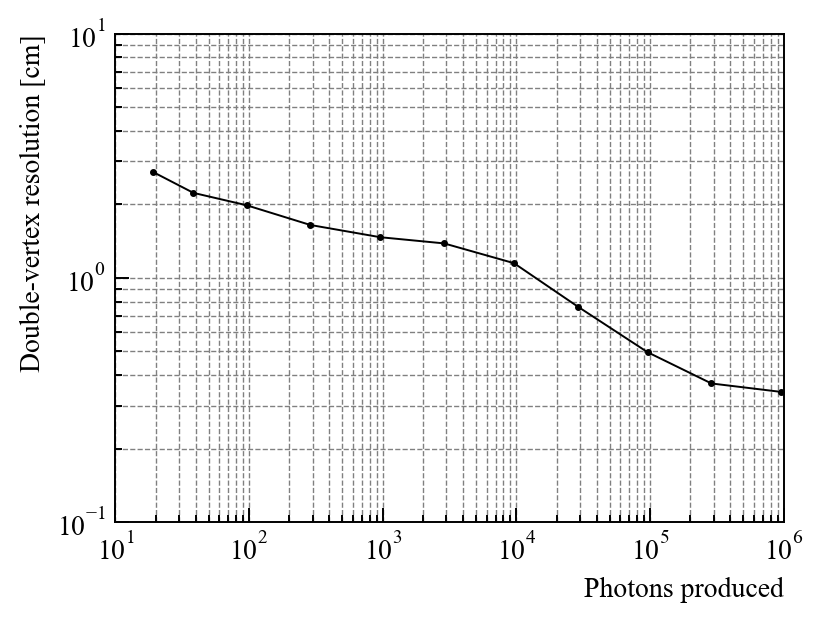

In [8]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.loglog(np.array(num_photons)*eff, resolutions/10., marker='.')
ax.set_xlabel('Photons produced')
ax.set_ylabel('Double-vertex resolution [cm]')
ax.set_xlim([1e1, 1e6])
ax.set_ylim([1e-1, 1e1])
ax.grid(which='both')

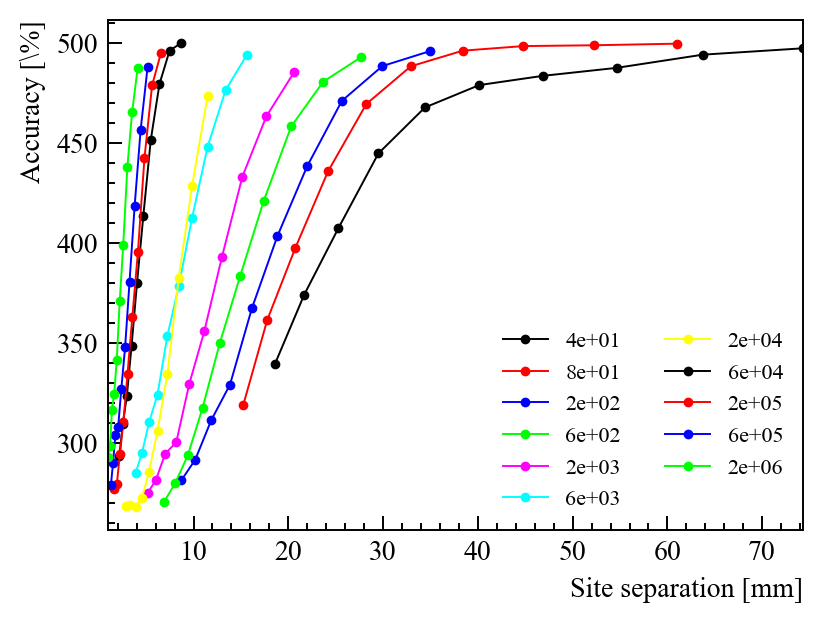

In [116]:
plt.style.use('paper_style.mplstyle')
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(seps_array, acc_test/1000*1e2, marker='.', ms=5, label=['{:.0e}'.format(n) for n in num_photons])
# [ax.axhline(k/1000*1e2, color='C1') for k in kept]#, label='Single-site accepted')
ind = np.argmin(np.abs(np.interp(np.linspace(0, np.amax(seps), 1000), seps, acc_test[:,-3]/5000*1e2) - 1e2*st.norm.cdf(1)))
# ax.axvline(np.linspace(0, np.amax(seps), 1000)[ind], ls='--', color='C2')
# ax.axhline(np.interp(np.linspace(0, np.amax(seps), 1000)[ind], seps, acc_test[:,-3]/1000*1e2), ls='--', color='C3')
ax.set_xlabel('Site separation [mm]')
ax.set_ylabel(r'Accuracy [\%]')
ax.set_xlim([np.amin(seps_array), np.amax(seps_array)])
ax.legend(ncol=2, fontsize=8)
fig.savefig('cnn_acc_vs_sep.png')

/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_29011/33582132.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(ncol=2, fontsize=8)


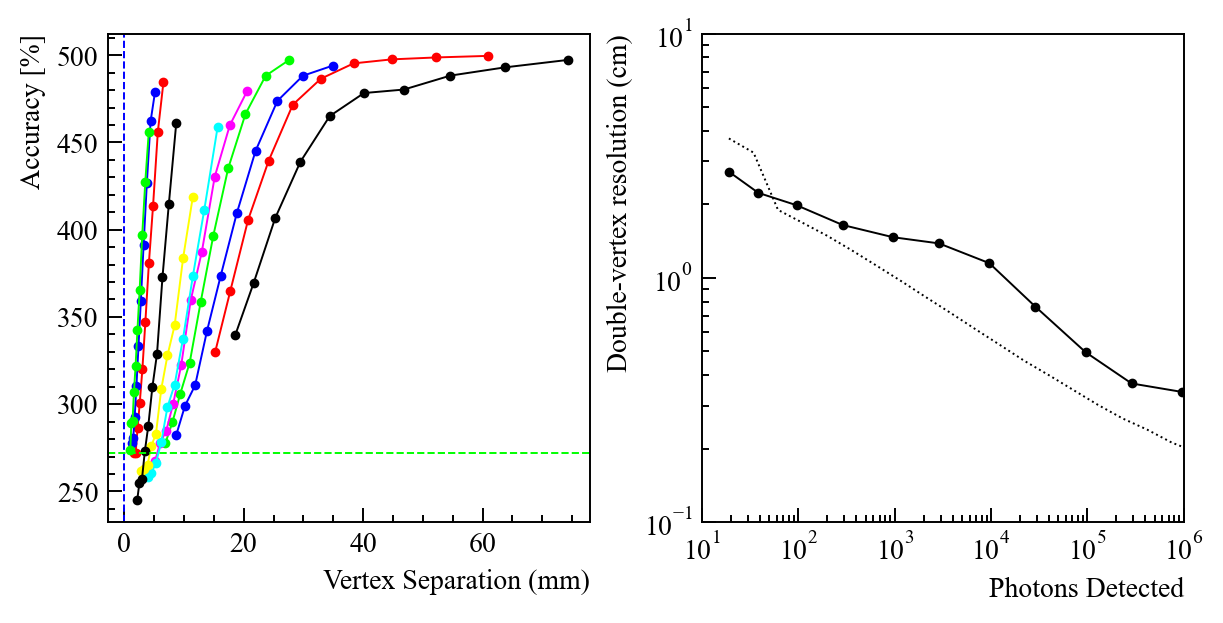

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')
ax[0].plot(seps_array, acc_test/1000*1e2, marker='.', ms=5, label=['{:.0e}'.format(n) for n in num_photons])
# [ax[0].axhline(k/1000*1e2, color='C1') for k in kept]#, label='Single-site accepted')
ind = np.argmin(np.abs(np.interp(np.linspace(0, np.amax(seps), 1000), seps, acc_test[:,-3]/1000*1e2) - 84.))
ax[0].axvline(np.linspace(0, np.amax(seps), 1000)[ind], ls='--', color='C2')
ax[0].axhline(np.interp(np.linspace(0, np.amax(seps), 1000)[ind], seps, acc_test[:,-3]/1000*1e2), ls='--', color='C3')
ax[1].loglog(np.array(num_photons)*eff, resolutions/10., marker='.', ms=5)
ax[1].loglog(crlb[:, 0], crlb[:, 1], ls=':', color='C0')
ax[1].set_xlim([1e1, 1e6])
ax[1].set_ylim([1e-1, 1e1])
ax[0].set_xlabel('Vertex Separation (mm)')
ax[1].set_ylabel('Double-vertex resolution (cm)')
ax[1].set_xlabel('Photons Detected')
ax[0].set_ylabel('Accuracy [%]')
ax[1].legend(ncol=2, fontsize=8)

np.savez('data/plot_data_{}.npz'.format(descrip), seps=seps_array, acc_test=acc_test, num_photons=num_photons, kept=kept, eff=eff, resolutions=resolutions)

/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:41: RuntimeWarning: divide by zero encountered in power
  return A*np.exp(-a*rho/(1 + rho**(1 - alpha)) - b/(1 + rho**(-alpha)))


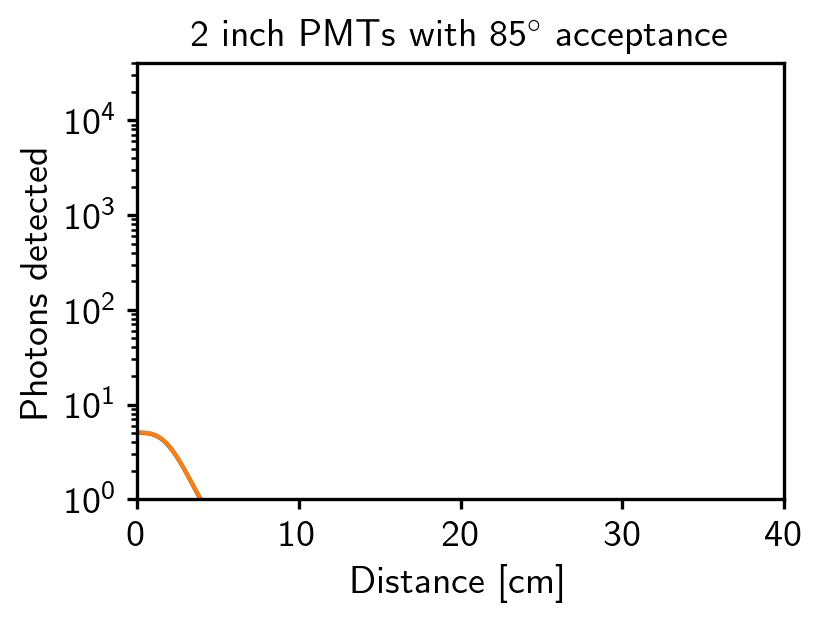

In [60]:
lrf_2inch_85deg_g4 = [2537.17/1e4*n_photons, 3.96, 0.88, 2.38, 3.16]
lrf_2inch_70deg_g4 = [2596.87/1e4*n_photons, 4.39, 4.62, -0.08, 2.86]

with open('data/LRF_51mm_85deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_85deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

with open('data/chroma/LRF_51mm_70deg.yaml', 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_70deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

rad_array = np.linspace(0, 40, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_chroma))
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_g4))
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 40])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 85$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_85deg.png')

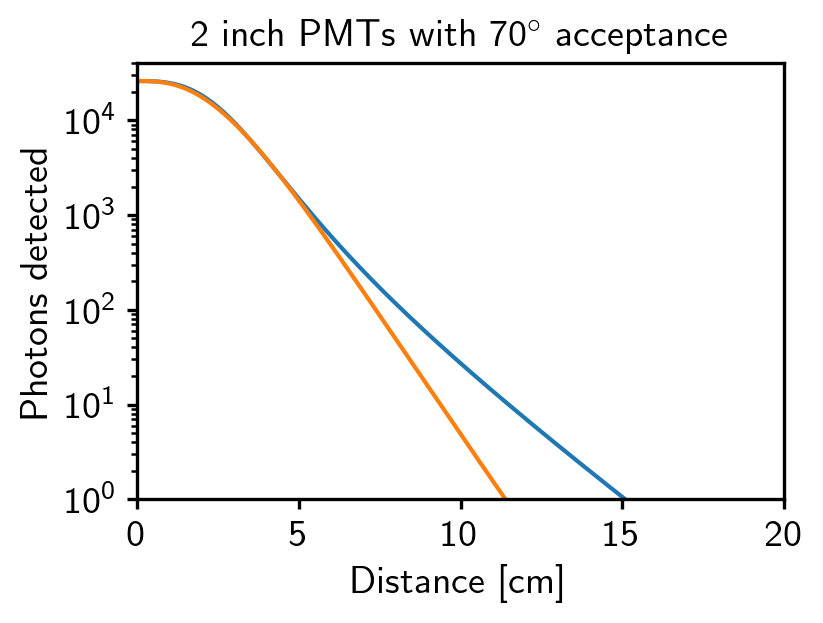

In [42]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_chroma), label='Chroma')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_g4), label='Geant4')
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 20])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 70$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_70deg.png')